<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Classification and Regression Trees (CARTs)

_Authors: Kiefer Katovich (SF), Matt Brems (DC)_

---

### Learning Objectives
- Get a sense of what decision trees do through examples.
- Learn the properties of decision tree models.
- Learn how decision trees are fit via pseudocode.
- Understand the concept of purity.
- Learn the entropy and Gini impurity equations and how they relate to the misclassification error.
- See how decision trees fit on examples where regressions fail.
- Learn how to visualize the nodes of a decision tree with Python.
- Learn some basic strategies to prevent overfitting when using decision trees.
- Understand the advantages and disadvantages of using CARTs.

### Lesson Guide
- [Hierarchical Decisions: 20 Questions](#20q)
- [Introduction to CARTs](#intro)
- [Properties of Decision Trees](#properties)
- [Example: Should We Play Golf?](#example)
- [Directed Acyclic Graphs (DAG)](#dag)
- [Building a Decision Tree](#building)
    - [Pseudocode of the Decision Tree Algorithm](#pseudo)
    - [Multiway Splits](#multi)
    - [Continuous Measure Decisions](#continuous)
- [Optimization and Purity](#purity)
    - [Purity Objective Function](#obj)
    - [Common Purity Functions](#ent-gini)
    - [Impurity and Gain](#impurity-gain)
- [Examples of Where Regression Fails](#reg-fail)
- [Explore Interactive Decision Tree Fits](#explore-tree)
- [Graph the Branches of a Decision Tree Using Python](#visualize-tree)
- [Addressing Overfitting](#overfit)
- [CART Advantages](#advantages)
- [CART Disadvantages](#disadvantages)

<a id='20q'></a>

## Hierarchical Decisions: 20 Questions

---

In the game "20 Questions," an individual or group has the opportunity to identify an unknown object by asking up to 20 "yes" or "no" questions.

For example, suppose that we are trying to guess the object "marker." We might ask a series of questions like:

- Is the object in this room? (Yes.)
- Is the object within five feet of us? (Yes.)
- Is the object larger than a loaf of bread? (No.)
- Is there only one of these objects in the room? (No.)
- Do you hold this object when you use it? (Yes.)
- Is the object a pen? (No.)
- Is the object a book? (No.)
- Is the object a marker? (Yes!)

We can think about all of the possible target objects and then ask questions that help us can identify the true target in 20 questions or less.

**When playing this game, what are some good strategies? What about some poor strategies?**

<a id='intro'></a>

## Introduction to CARTs

---

CART decision trees are a widely popular and powerful machine learning technique, used for both classification and regression problems.

To perform classification or regression, decision trees make sequential, hierarchical decisions about the outcome variable based on the predictor data.

---

- [Classification CART documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

- [Regression CART documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor).

- [Decision tree user guide](http://scikit-learn.org/stable/modules/tree.html).



In [1]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import sklearn.datasets as datasets

b = datasets.load_boston()
X, Y = b['data'], b['target']

# Criterion: Here we're splitting the decision function (discussed later); it can be "Gini" or "entropy."
# max_depth: The maximum number of hierarchical decision nodes (how "deep" the tree is built).
#
classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=None)

regressor = DecisionTreeRegressor(criterion='mse',
                                  max_depth=5)

regressor.fit(X, Y)

Y_pred = regressor.predict(X)

# Decision trees can tell us the importance of features. The higher the number, the more important
# the predictor is to deciding node splits.
# The importance of a feature is computed as the (normalized) total reduction of the 
# criterion brought by that feature.
#
feature_importances = regressor.feature_importances_

<a id='properties'></a>
## Properties of Decision Trees

---

Decision tree models are **hierarchical** and **nonparametric**.

**Hierarchical** means that the model is defined by a sequence of questions that yield a class label or value when applied to an observation. Once trained, the model uses a series of "if, then" conditions that yield a specific result for our input data.

[**Nonparametric** methods](http://www.statisticshowto.com/parametric-and-non-parametric-data/) contrast with models like logistic regression and ordinary least squares regression. There are no underlying assumptions about the distribution of the data or the errors in nonparametric models. Essentially, they start with no _assumed_ parameters about the data and instead construct parameters based on the observed data.

<a id='example'></a>
## Example Decision Tree: Should We Play Golf?

---

![deciding to play golf](./images/golf-tree.png)

<a id='dag'></a>
## Directed Acyclic Graphs (DAG)

---

CART models are a special case of [directed acyclic graphs (DAG)](http://www.statisticshowto.com/directed-acyclic-graph/).

DAGs have **nodes** and **edges**. In the golf example above, the nodes represent the decision points about the output variable given the predictors, while the edges are the paths between nodes that represent answers to the questions.

DAGs are **acyclic** because the edges don't cycle back on themselves.

- The top node is called the **root node**. It has zero incoming edges and two or more outgoing edges. 
- Internal nodes test a condition on a specific feature. They have one incoming edge and two or more outgoing edges. 
- A **leaf node** contains a class label (or regression value). It has one incoming edge and zero outgoing edges.

### General DAG Example

---

![DAG example](https://upload.wikimedia.org/wikipedia/commons/0/08/Directed_acyclic_graph.png)

<a id='building'></a>
## Building a Decision Tree

---

Building decision trees requires algorithms that are capable of determining an optimal choice at each node. 

One example is [**Hunt's algorithm**](http://mines.humanoriented.com/classes/2010/fall/csci568/portfolio_exports/lguo/decisionTree.html). This is a greedy, recursive algorithm that leads to a local optimum:

- [**Greedy**](https://en.wikipedia.org/wiki/Greedy_algorithm): The algorithm makes the most optimal decision it can at each step.
- [**Recursive**](https://en.wikipedia.org/wiki/Recursion): The algorithm splits task into subtasks and solves each the same way.
- [**Local optimum**](https://en.wikipedia.org/wiki/Local_optimum): The algorithm finds a solution just for the given neighborhood of points.

The algorithm works by recursively splitting records into smaller and smaller subsets. This decision is made at each node according to a metric called **purity.** A node is 100-percent pure when all of its records belong to a single class (or have the same value).

<a id='pseudo'></a>
### Pseudocode of the Decision Tree Algorithm

---

    Given a set of records, Dt, at node t:
        If all records in Dt belong to class A: 
            t is a leaf node corresponding to class (base case).
        Else if Dt contains records from both A and B:
            Create test condition to partition the observations.
            Define t as an internal node with outgoing edges to child nodes.
            Partition records in Dt with conditional test logic to child nodes.
            Recursively apply steps at each child node.

- Splits can be binary-way or multiway. 
- Features can be categorical or continuous.

<a id='multi'></a>
### Multiway Splits

---

![multi-way](./images/multi-way.png)

<a id='continuous'></a>
### Continuous Measure Decisions (Regression Trees)

---

![continuous trees](./images/Continuous-features.png)

<a id='purity'></a>
## Optimization and Purity

---

Recall from the algorithm above that we iteratively create test conditions to split the data. 

In a binary classification task, a maximum impurity partition is given by the distribution:

### $$ p(0|t) = p(1|t) = 0.5 $$

Where both classes are equally present in the partition distribution, $t$.

Maximum purity, on the other hand, is when only one class is present: 

### $$ p(0|t) = 1 – p(1|t) = 1 $$

<a id='obj'></a>
### Purity Objective Function

To achieve maximum purity, we need to optimize an **objective function**. 

We want our objective function to measure the **gain in purity** from a particular split. Therefore it depends on the class distribution over the nodes (both before and after the split). 

For example, let...

### $$p(i|t)$$ 

...be the probability of **`class i`** in the data at **`node t`** (e.g., the fraction of records labeled **`i`** at node **`t`**). 

We then define an impurity function that will vary between the two extreme cases of minimum impurity (one class or the other only) and maximum impurity equally.

<a id='ent-gini'></a>
## Common Purity Functions (Classification)

---

### $$ \text{Entropy} = - \sum_{i=1}^{classes} p(i\;|\;t) \;log_2 \; p(i\;|\;t) $$

### $$ \text{Gini} = \sum_{i=1}^{classes} p(i\;|\;t)(1 -p(i\;|\;t)) = 1 - \sum_{i=1}^{classes} p(i\;|\;t)^2 $$

The Gini impurity is primarily used in the CART algorithm, but both Gini and entropy are available in scikit-learn's classification and decision tree models.

<a id='impurity-gain'></a>
![purity functions](./images/measures.png)

---

On their own, impurity measures aren't enough to tell us how a split will do. We need to look at impurity **before and after** the split. We can make this comparison using what's called a **gain**: 

## $$ \Delta = I(\text{parent}) - \sum_{\text{children}}\frac{N_j}{N}I(\text{child}_j) $$

Where $I$ is the impurity measure, $N_j$ denotes the number of records at child node $j$, and $N$ denotes the number of records at the parent node. When $I$ is the [**entropy function**](https://en.wikipedia.org/wiki/Binary_entropy_function), it's called the [**information gain**](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees).

Here is a nice example of **[how misclassification error can break branching](http://sebastianraschka.com/faq/docs/decisiontree-error-vs-entropy.html)**.

**Library Note**

In order to run the code below on your machine, you may have to install or update a few packages.

**Pydotplus**:
```
pip install pydotplus
```

_And its dependency:_

**Graphviz**:
```
brew install graphviz
```

In [2]:
import numpy as np
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor

from ipywidgets import *
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(9, 7))
sns.set_style('whitegrid')

%matplotlib inline

In [3]:
# We'll make some data for these functions of 100 points of x from 0.1 to 10:
# 
# 1) The general log function for x.
# 2) The sin function.
# 3) The exponential function.
# 4) The x**2 function.
#
def make_data(points=100):
    x = np.linspace(0.1, 10, points)
    
    data = {
        'x':x,
        'ygenlog':stats.genlogistic.pdf(x, 20)*500 + np.random.normal(0, 2, size=points),
        'ysin':np.sin(x)*20 + np.random.normal(0, 2, size=points),
        'yexp':np.exp(x/1.3) + np.random.normal(0, 2, size=points),
        'ysq':(x-5)**2 + np.random.normal(0, 1, size=points)
    }

    return data

# The data are put into a dictionary for convenience.
d = make_data()
x = d['x']

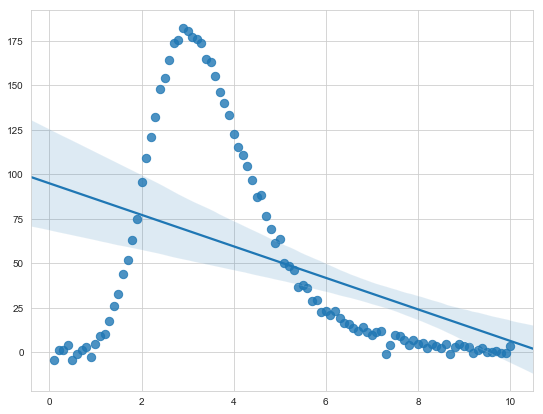

In [4]:
fig = plt.figure(figsize=(9, 7))
sns.regplot(x=x, y=d['ygenlog'], scatter_kws={'s':70})

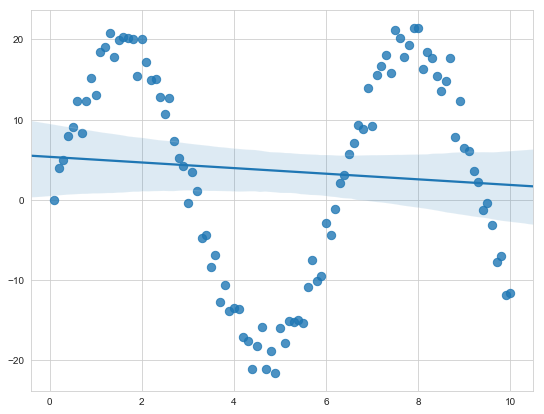

In [5]:
fig = plt.figure(figsize=(9, 7))
sns.regplot(x=x, y=d['ysin'], scatter_kws={'s':70})

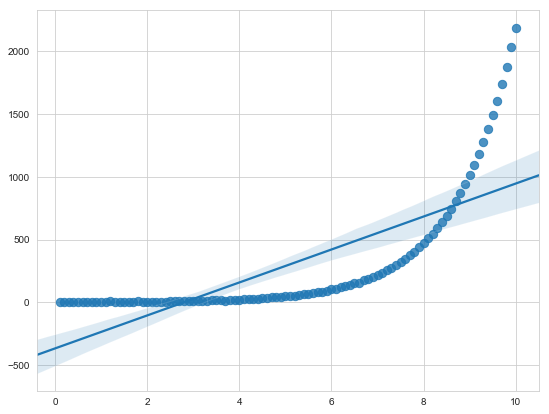

In [6]:
fig = plt.figure(figsize=(9, 7))
sns.regplot(x=x, y=d['yexp'], scatter_kws={'s':70})

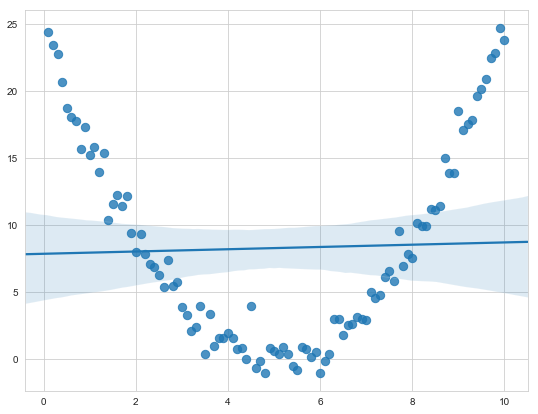

In [7]:
fig = plt.figure(figsize=(9, 7))
sns.regplot(x=x, y=d['ysq'], scatter_kws={'s':70})

In [8]:
# This function builds trees for an x and y predictor 
# and a dependent variable with a depth from one to 10 (regression trees).
# Tree predictions are put into a dictionary.
def build_tree_models(x, y, tree_depth_range=range(1,11)):
    tree_model_ypreds = {}
    
    for i in tree_depth_range:
        model = DecisionTreeRegressor(max_depth=i)
        model.fit(x[:, np.newaxis], y)
        tree_model_ypreds[i] = model.predict(x[:, np.newaxis])
        
    return tree_model_ypreds

# Below is a function to iterate through our data dictionary 
# of different functions to build the tree models.
def fit_trees(data_dict):
    trees_dict = {}
    x = data_dict['x']
    for label, ys in data_dict.items():
        if not label == 'x':
            tree_ys = build_tree_models(x, ys)
            trees_dict[label] = tree_ys
    
    return trees_dict

tr = fit_trees(d)
    

In [9]:
# This function plots the x and y data, as well as 
# the decision tree's decisions for the predicted y value.
def tree_plotter(d, tr, label, treenum):
    fig = plt.figure(figsize=(9, 7))
        
    x = d['x']
    y_true = d[label]
    y_pred = tr[label][treenum]
    
    ax = sns.regplot(x=x, y=y_true, scatter_kws={'s':70}, fit_reg=False, x_ci=None, ci=None)
    
    ax.plot(x, y_pred, c="#D7B734", linewidth=5)
    
    ax.set_title('Tree depth: '+str(treenum)+'\n', fontsize=20)
    
    plt.show()
    

# Widget inputs code.
#
def tree_plot_vars(function='ysq', treenum=1):
    tree_plotter(d, tr, function, treenum)
    

In [10]:
widgets.interact(tree_plot_vars,
                 function=['ysq','yexp','ysin','ygenlog'],
                 treenum=widgets.IntSlider(min=1, max=10, step=1, continuous_update=False, value=1))


interactive(children=(Dropdown(description='function', options=('ysq', 'yexp', 'ysin', 'ygenlog'), value='ysq'…

<function __main__.tree_plot_vars(function='ysq', treenum=1)>

In [11]:
# Make a single regression tree model with a depth of three for the x**2 function.

x = d['x']
y = d['ysq']

dtree = DecisionTreeRegressor(max_depth=5)
dtree.fit(x[:, np.newaxis], y)


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

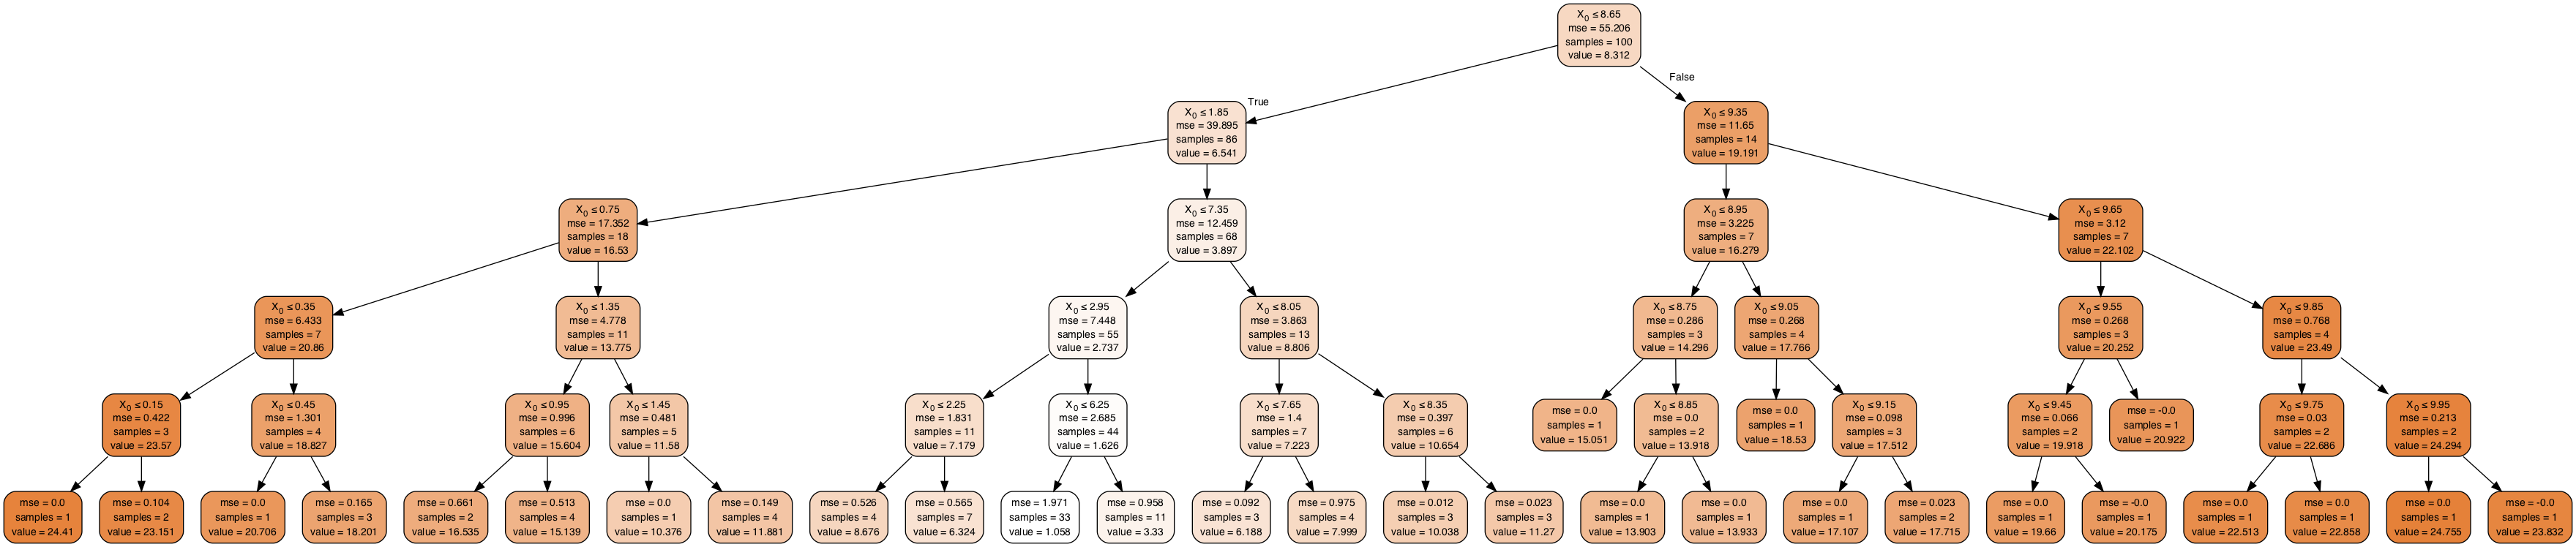

In [12]:
# Requirements:
# Pip install pydot2.
# Brew install Graphviz.

# Use Graphviz to make a chart of the regression tree decision points.
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()  

export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

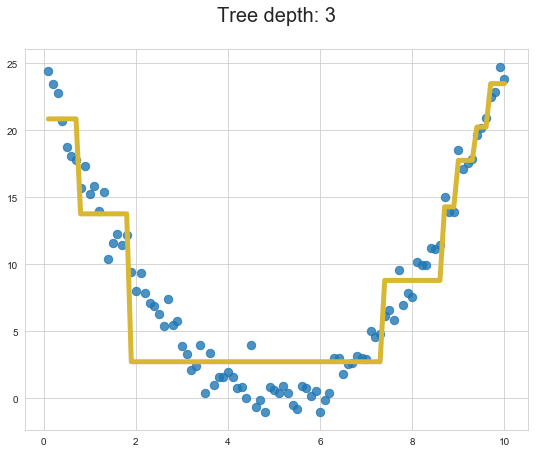

In [13]:
# Plot the decisions for y based on the decision tree DAG above.
#
tree_plotter(d, tr, 'ysq', 3)

<a id='overfit'></a>
## Addressing Overfitting

---

A stopping criterion determines when the model should no longer construct further nodes. 

We can stop constructing nodes when all records belong to the same class or have the same attributes. This *maximizes variance at the expense of bias*, which leads to overfitting. 

**Setting a maximum depth:**

A simple way to prevent overfitting is to set a hard limit on the depth of the decision tree.

**Minimum observations to make a split:**

An alternative to maximum depth is to specify the minimum number of data points required to make a split at a node. This can be used simultaneously with maximum depth. 


<a id='advantages'></a>
## CART Advantages
---

- They're simple to understand and interpret. People are able to understand decision tree models after a brief explanation.
    - Useful for working with non-technical departments (marketing/sales).
- Requires little data preparation. 
    - Other techniques often require data normalization, dummy variables, and the removal of blank values.
- They're able to handle both numerical and categorical data. 
    - Other techniques usually specialize in analyzing data sets that have only one type of variable.
- Uses a **white box** model.
    - If a given situation is observable in a model, the explanation for the condition can be easily explained by Boolean logic.
    - By contrast, in a **black box** model, the explanation for the results is typically difficult to understand.
- It's possible to validate a model using statistical tests, which helps account for the reliability of the model.
- CART models are robust. They perform well even if their assumptions are somewhat violated by the true model from which the data were generated.
- They perform well with large data sets. Large amounts of data can be analyzed using standard computing resources in reasonable time.
- Once trained, CART models can be implemented on hardware and have extremely fast execution times.
    - Real-time applications include trading, for example.

<a id='disadvantages'></a>
## CART Disadvantages
---

- CART models are locally optimal.
    - Practical decision tree learning algorithms are based on heuristics such as the greedy algorithm, where locally optimal decisions are made at each node. 
    - Such algorithms aren't guaranteed to return a globally optimal decision tree.
- There's the problem of overfitting.
    - Decision tree learners can create overly complex trees from the training data that don't generalize well.
- Some concepts are difficult to learn because decision trees don't express them easily (e.g., XOR, parity, or multiplexer problems). In such cases, the decision tree becomes too large.
    - Neural networks, for example, are superior for these problems.
- Decision tree learners create biased trees if some classes dominate. We therefore recommend balancing the data set prior to fitting with the decision tree.